# __Calculs de séries temporelles moyennées sur plusieurs bassins versants à partir de centaines de milliers de grilles ERA5-Land stockées sur le cloud....le tout en quelques secondes!__

Ce bloc-note présente une stratégie pour calculer des séries temporelles moyennées à un bassin versant (représenté par un fichier de polygone de type geojson ou shapefile) à partir de centaines de milliers de grilles (telles que la température, le vent, les précipitations, la neige au sol , la couverture de nuages, la radiation nette au sol, ainsi que des dizaines d'autres variables) stockées sur le cloud. Plus spécifiquement, les données de réanalyse d'ERA5-Land, disponibles pour la zone du Québec, de l'Ontario et du nord-est des États-Unis, et dont la taille fait 2.3 TB seront analysés, le tout en quelques secondes seulement.

Comment est-il possible d'atteindre cet objectif? __Tout simplement en évitant de télécharger 2.3TB vers notre ordinateur local (ce qui prendrait des jours) et en profitant des nouveaux formats de stockages de données de grilles (zarr, tileDB, geotiff optimisé pour l'infonuagique.)__ Pour cet exemple, les données ERA5-Land sont disponibles en format zarr.

Notez que ce bloc-note peut être exécuté sur un poste local avec les configurations et l'environnement adéquat ou alors dans le cloud. Cet exemple est originalement exécuté sur une seule machine virtuelle dans le cloud, mais pourrait être facilement exécutée sur un cluster de centaines de coeurs si requis, notamment avec l'orchestrateur de conteneurs Kubernetes. Pour plus d'informations sur l'environnement requis (lorsque python est utilisé) :

https://github.com/sebastienlanglois/zarr-experiments/blob/master/binder/environment.yml 

Pour exécuter une cellule, il suffit de cliquer sur Shift+Enter. Notez que les cellules doivent être exécutées dans l'ordre de haut en bas pour assurer la cohérence dans l'exécution.

__Précisions techniques (*pour les intéressé(e)s*) : __

- Zarr : https://zarr.readthedocs.io/en/stable/

Zarr est une librairie qui permet de partitionner et compresser efficacement des matrices de dimensions N. Le format zarr a été testé avec succès sur des jeux de données de l'ordre du PB (petabytes). Il existe aujourd'hui beaucoup de grands jeux de données (TBs, PBs) qui sont disponibles en format zarr gratuitement (CMIP6, ERA5, TRMM, GMET, HydroSheds, etc.) et il est prévu que d'ici 2025, 350 PB de données de grilles seront importées dans le cloud, par la NASA seulement! Par ailleurs, il existe des wrappers et librairies dans plusieurs languages de programmation pour accéder à zarr (Julia, R, C++, Python).

- Dask : https://dask.org/

Dask est une librairie qui permet de planifier et optimiser les tâches à exécuter (lazy loading) puis de distribuer le calcul sur les coeurs disponibles sur une machine ou un cluster. Dask s'apparente à Spark et est utilisé pour traiter, distribuer et analyser des volumes de données importants (TB). Dask est compatible avec d'autres librairies typiques de python (pandas, numpy, scipy, tensorflow, etc.)

- Xarray : http://xarray.pydata.org/en/stable/

Xarray est une librarie reposant sur Dask qui permet d'analyser et de traiter des matrices de dimensions N avec des métadonnées (coordonnées, temps, etc.). Xarray propose aussi plusieurs apis pour interagir avec plusieurs types de format classiques dans le domaine géospatial (netcdf, grib, geotiff, ascii, csv (xyz), zarr, etc).


Date: Janvier 19, 2020

Créé par : Sébastien Langlois

In [1]:
# Librairies nécessaires
import xarray as xr
import geopandas as gpd
import fsspec
import numpy as np
from rasterio import features
from affine import Affine
import pandas as pd
import hydrotools as ht
import os
import matplotlib.pyplot as plt
import warnings
import s3fs
from distributed import Client, progress
warnings.filterwarnings('ignore')

# Client Dask
Mise en oeuvre d'un client dask qui permet de planifier (lazy loading) et paralléliser les processus/threads entre les coeurs d'une machine seule ou d'un cluster, selon le cas. Compatible avec un orchestrateurs de conteneurs, par exemple Kubernetes, si requis.

![title](img/grid_search_schedule.gif)

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35257 Dashboard: http://127.0.0.1:38179/status,Cluster Workers: 8 Cores: 32 Memory: 135.11 GB


# Repertoires

In [3]:
# Repertoire contenant les geojson (équivalent à des polygones de type "shapefile", mais accessible en un seul fichier)
polygon_files = 's3://watersheds-polygons/MELCC/json'

# Nom du bucket contenant les donnees ERA5-Land
bucket='s3://era5-atlantic-northeast/zarr/land/reanalysis'


# Configs

In [4]:
# Url du serveur contenant le bucket
client_kwargs={"endpoint_url":"https://s3.us-east-2.wasabisys.com"}

# Geopandas

Geopandas permet de lire un ou plusieurs fichiers contenant des polygones (geojson, shapefiles, etc.), de présenter les métadonnées sous forme de dataframe (tableau) et d'interagir avec celles-ci

In [5]:
# Shapefiles/json to geopandas
gdf = ht.files_to_gdf(url=polygon_files,
                      client_kwargs=client_kwargs)  
gdf

,Altitude,Descriptio,Etat,Inclus,Latitude,Longitude,Nom,OBJECTID,Proprietai,Regime,...,Shape_Area,Shape_Le_1,Shape_Leng,Station,Sup_Diffus,Sup_Km,Type,Type_stat,geometry,tp
0,50.3,"à 2,3 km en amont de la branche ouest",Fermé,oui,48.4777777778,-64.52861111110001,La Grande Rivière,1,MENV,Naturel,...,0.0652761069343,1.97437542906,169650.548302,ST_010101,NaN,530.602589599,NaN,Débit,"POLYGON ((-64.63738 48.69413, -64.63620 48.693...",010101
1,15.2,"à 9,7 km en amont du pont-route 132",Fermé,oui,48.1000238888,-65.4609027022,Bonaventure,2,MENV,Naturel,...,0.259261186252,3.50969600722,314860.080669,ST_010801,NaN,2112.20913932,NaN,Débit,"POLYGON ((-65.72905 48.91156, -65.72881 48.911...",010801
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,010802,1911,NaN,D,NaN,"POLYGON ((-65.74079 48.92132, -65.74000 48.921...",NaN
3,6.1,"à 3,9 km en amont du pont du C.N.",Fermé,oui,48.1905277778,-65.8113888889,Petite rivière Cascapédia,3,MENV,Naturel,...,0.172376406678,2.8303956776,255679.630187,ST_010901,NaN,1402.55385323,NaN,Débit,"POLYGON ((-65.78048 48.89303, -65.77983 48.892...",010901
4,27.4,"à 0,9 km rive gauche aval du pont route-couver...",Ouvert,oui,48.2321388889,-65.7330555556,Petite rivière Cascapédia,1,MENV,Naturel,...,0.163750210875,2.74484812698,247972.539999,ST_010902,NaN,1331.85452372,NaN,Débit,"POLYGON ((-65.78048 48.89303, -65.77983 48.892...",NaN
5,25,à 0.9 km rive droite aval pont-route couvert ...,Fermé,oui,48.232225,-65.73394999999999,Petite rivière Cascapédia,4,MENV,Naturel,...,0.16374664998,2.74467176046,247943.775209,ST_010903,NaN,1331.82533181,NaN,Débit,"POLYGON ((-65.78048 48.89303, -65.77983 48.892...",010903
6,147.8,"à 1,4 km en aval de la branche du lac",Fermé,oui,48.6664156416,-66.188701553,Cascapédia,5,MENV,Naturel,...,0.180294744943,2.55244209917,220749.462498,ST_011001,NaN,1461.48728416,NaN,Débit,"POLYGON ((-66.35506 48.95639, -66.35493 48.956...",011001
7,36.6,"à 1,3 km en amont de l'Angers",Fermé,oui,48.3178013298,-65.9717575662,Cascapédia,6,MENV,Naturel,...,0.292686667481,3.59970406747,314827.202446,ST_011002,NaN,2376.18438873,NaN,Débit,"POLYGON ((-66.35506 48.95639, -66.35493 48.956...",011002


Par exemple, visualisons le premier polygone dans le tableau ci-dessus.

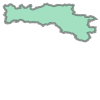

In [6]:
gdf.iloc[0].geometry

# Xarray Dataset
![title](img/dataset-diagram.png)

19 variables ERA5-Land sont disponibles dans le bucket. Leurs métadonnées peuvent être brièvement consultées ci-dessous.


In [7]:
#Mapping vers filesystem depuis le bucket
store = fsspec.get_mapper(url=bucket,
                          client_kwargs=client_kwargs,
                          anon=True)

# Ouverture du zarr vers dataset (xarray)
ds = xr.open_zarr(store,
                  consolidated=True,
                  chunks='auto')
ds

<xarray.Dataset>
Dimensions:    (latitude: 231, longitude: 441, time: 339648)
Coordinates:
  * latitude   (latitude) float32 63.0 62.9 62.8 62.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 -96.0 -95.9 -95.8 -95.7 ... -52.2 -52.1 -52.0
  * time       (time) datetime64[ns] 1981-01-01 ... 2019-09-30T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    licd       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sde        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sf         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    smlt       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    snowc      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tsn        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-14 15:35:10 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

1- Vérifions que les données sont bel et bien accessibles. Prenons par exemple la variable sd (EEN) pour l'année 2000 et la coordonnée (50,-70) :

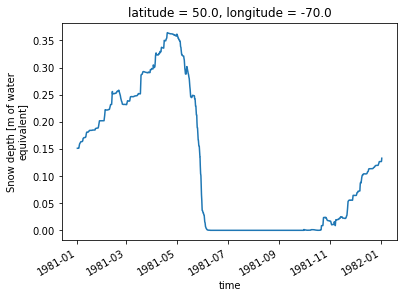

In [32]:
(ds.sd.sel(latitude=50, 
            longitude=-70,
            time=slice('1981-01-01', '1982-01-01'))).plot()

2- Vérifions que les données sont bel et bien accessibles. Prenons la grille de la variable sd (EEN) pour à 2019-01-01T01:00:00 :

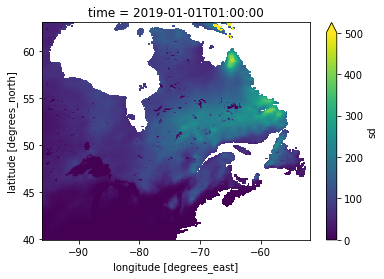

In [9]:
# *1000 pour convertir de mètres vers millimètres
(ds.sd.sel(time='2019-01-01T01:00:00')*1000).plot(vmax=500)

Pour plus d'informations sur les variables disponibles :

In [10]:
# ds.variables

Prenons par exemple la variable sd (snow depth water equivalent) :

# Application des moyennes bassins (xarray vers dataframe)
Une fonction simple *clip_polygon_to_dataframe()* a été utilisée pour appliquer les grilles sur chacun des polygones préalablement définis dans le tableau plus haut (geopandas). Cette fonction permet également d'ajuster les fuseaux horaires et faire des opérations de réduction sur les matrices de données. Assumant que la bande passante soit d'au moins 200-300Mbit/s (ce qui est le cas dans le cloud), le calcul ne devrait pas prendre plus de 1-2 secondes par bassin en moyenne. Notons qu'il serait possible d'améliorer ce temps de calcul en optimisant la fonction *clip_polygon_to_dataframe()*

In [11]:
%%time

df = ht.clip_polygon_to_dataframe(dataset=ds,
                                  geodataframe=gdf, # prendre seulement les 3 premiers pour fin de tests
                                  geodf_index_column='Station',
                                  variable='sd',  
                                  aggregation='mean',
                                  resample_time='1D',
                                  from_tz='UTC',
                                  to_tz='America/Montreal',
                                  latlng_names=['latitude',
                                                'longitude']
                                  )
# Convertir vers le format de l'IC
# df.index = df.index.tz_convert(None).normalize() + pd.DateOffset(days=1)

ST_010101
ST_010801
010802
ST_010901
ST_010902
ST_010903
ST_011001
ST_011002
CPU times: user 3.02 s, sys: 331 ms, total: 3.35 s
Wall time: 13.6 s


# Dataframe (Tableau)

In [11]:
df

,level,ST_010101,level,ST_010801,level,010802,level,ST_010901,level,ST_010902,level,ST_010903,level,ST_011001,level,ST_011002
time,,,,,,,,,,,,,,,,
1978-12-31 00:00:00-05:00,1000,2486.319824,1000,2485.945312,1000,2485.945312,1000,2461.449219,1000,2461.449219,1000,2461.449219,1000,2366.961182,1000,2383.916260
1979-01-01 00:00:00-05:00,1000,1240.200684,1000,1225.327881,1000,1225.327881,1000,1192.351196,1000,1192.351196,1000,1192.351196,1000,1089.015259,1000,1107.841919
1979-01-02 00:00:00-05:00,1000,468.957031,1000,450.010742,1000,450.010742,1000,422.262054,1000,422.262054,1000,422.262054,1000,375.172150,1000,382.465546
1979-01-03 00:00:00-05:00,1000,-38.286701,1000,31.318563,1000,31.318563,1000,54.197590,1000,54.197590,1000,54.197590,1000,127.735619,1000,117.482094
1979-01-04 00:00:00-05:00,1000,1777.846069,1000,1795.933838,1000,1795.933838,1000,1772.290161,1000,1772.290161,1000,1772.290161,1000,1709.593384,1000,1721.412720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27 00:00:00-05:00,1000,1328.038940,1000,1341.510498,1000,1341.510498,1000,1332.405762,1000,1332.405762,1000,1332.405762,1000,1319.419678,1000,1322.929321
2019-12-28 00:00:00-05:00,1000,541.558411,1000,635.656677,1000,635.656677,1000,685.655579,1000,685.655579,1000,685.655579,1000,784.652161,1000,770.943420
2019-12-29 00:00:00-05:00,1000,1225.935181,1000,1305.292603,1000,1305.292603,1000,1354.145874,1000,1354.145874,1000,1354.145874,1000,1450.912598,1000,1436.646362


# Visualisation rapide

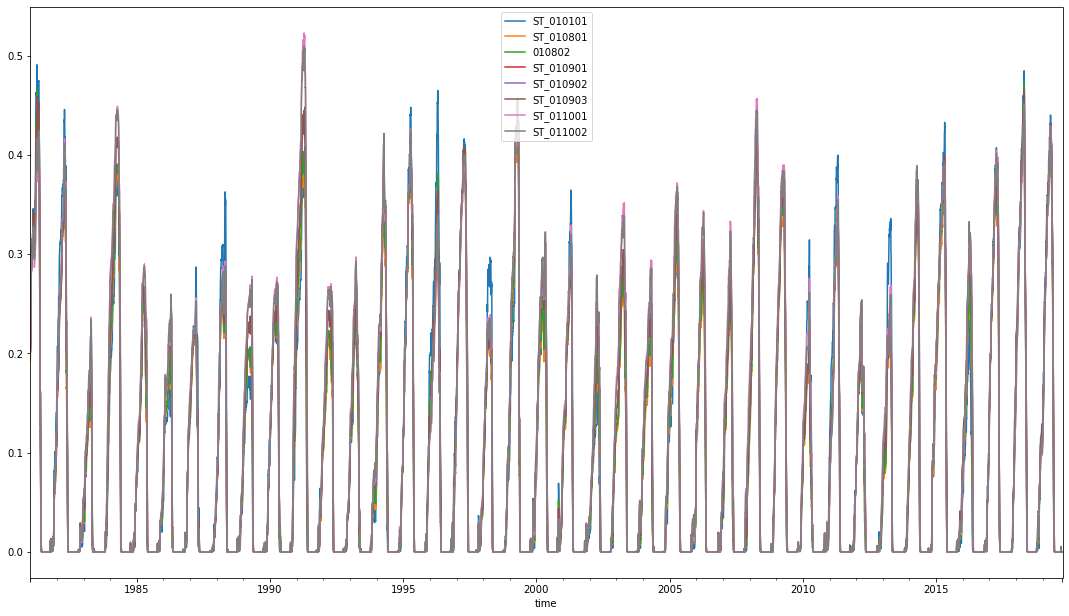

In [11]:
df.plot()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Stockage des résultats et téléchargement localement

In [12]:
# Choisir un nom de fichier .csv pour sauvegarder les résultats :
nom_fichier = 'era5-land-cehq.csv'


s3 = s3fs.S3FileSystem(client_kwargs=client_kwargs,
                               anon=True)  # public read

with s3.open('s3://analytics-store/' + nom_fichier,'w') as f:
    df.to_csv(f,
              encoding='latin-1')
    


Les données peuvent être téléchargées à l'adresse suivante :
https://s3.us-east-2.wasabisys.com/analytics-store/<nom_fichier>
    
Par exemple, si nom_fichier = 'era5-land-cehq.csv', alors le l'adresse serait :
https://s3.us-east-2.wasabisys.com/analytics-store/era5-land-cehq.csv

Notez que le fichier pourrait être détruit par d'autres utilisateurs dans le cloud après votre utilisation. Il est recommandé d'utiliser votre propre répertoire privé dans le cloud pour y télédéverser vos fichiers finaux ou télécharger immédiatement vos fichiers à partir des liens montrés ci-dessus.